In [14]:
%matplotlib inline

import os,sys
root = os.path.realpath(os.path.join(os.getcwd(), ".."))
sys.path.append(root)

from common import *
from common.notebook_utils import *
from common.scoring import calculate_fid_given_images

checkpoint_dir, data_dir = paths("dcgan-I")
last_checkpoint_epoch = 35 # 45
seed(999)

Random Seed:  999


In [15]:
fresh_start = False

In [16]:
num_workers = 2  # Number of workers for dataloader
batch_size = 128 # Batch size during training
image_size = 64  # Spatial size of training images. All images will be resized to this size using a transformer.
nc = 3           # Number of channels in the training images. For color images this is 3
nz = 100         # Size of z latent vector (i.e. size of generator input)

ngf = 64   # Size of feature maps in generator
ndf = 64   # Size of feature maps in discriminator

checkpoint_period = 5 # Checkpoint period

num_epochs = 0 # Number of training epochs

lr = 0.0002 # Learning rate for optimizers

beta1 = 0.5 # Beta1 hyperparam for Adam optimizers

ngpu = 1    # Number of GPUs available. Use 0 for CPU mode.

In [17]:
print(torch.cuda.is_available())

False


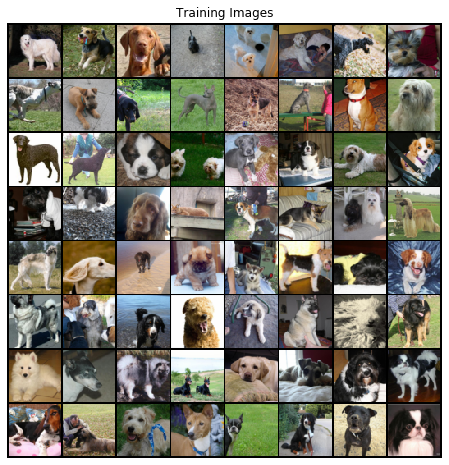

In [18]:
# Create the dataloader
dataloader = make_dataloader(data_dir, image_size, batch_size, num_workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
plot_training_images(dataloader, device)

In [19]:
print(device)

cpu


In [20]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Generator Code
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)
    
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [21]:
# Start epoch
start_epoch = 0

# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
#print(netG)

# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
#print(netD)

# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

G_losses = []
D_losses = []
iters = 0

if not fresh_start:
    start_epoch, netG, netD, criterion, fixed_noise, optimizerG, optimizerD, G_losses, D_losses, iters = load_checkpoint(netG, netD, criterion, fixed_noise, optimizerG, optimizerD, G_losses, D_losses, iters, join(checkpoint_dir,  f"state_{last_checkpoint_epoch}.pth"), device)
    netG.to(device)
    netD.to(device)
    
    # now individually transfer the optimizer parts...
    for state in optimizerG.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.to(device)

    # now individually transfer the optimizer parts...
    for state in optimizerD.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.to(device)


# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

=> loading checkpoint 'C:\Users\Kumo\Documents\GitHub\dogganit\checkpoints\dcgan-I\state_35.pth'
=> loaded checkpoint 'C:\Users\Kumo\Documents\GitHub\dogganit\checkpoints\dcgan-I\state_35.pth' (epoch 36)


In [22]:
# Training Loop

total_epochs = start_epoch + num_epochs

# Lists to keep track of progress
img_list = []

print("Starting Training Loop...")
# For each epoch
for epoch in range(start_epoch, total_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, total_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
    if np.mod(epoch, checkpoint_period) == 0:
        state = {
                'epoch': epoch + 1,
                'netG_state_dict': netG.state_dict(),
                'netD_state_dict': netD.state_dict(),
                'criterion': criterion,
                'fixed_noise': fixed_noise,
                'optimizerG_state_dict': optimizerG.state_dict(),
                'optimizerD_state_dict': optimizerD.state_dict(),
                'G_losses': G_losses,
                'D_losses': D_losses,
                'iters': iters
                }
        torch.save(state, '%s/state_%d.pth' % (checkpoint_dir, epoch))

Starting Training Loop...


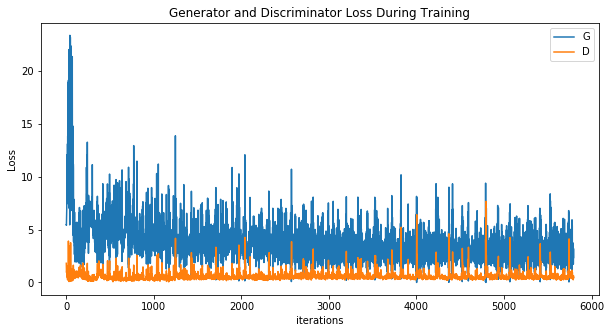

In [23]:
plot_losses(G_losses, D_losses)

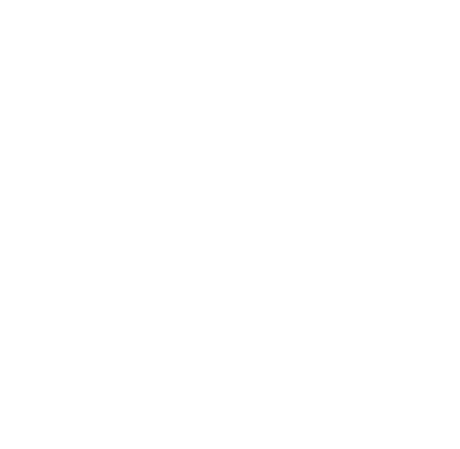

In [24]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

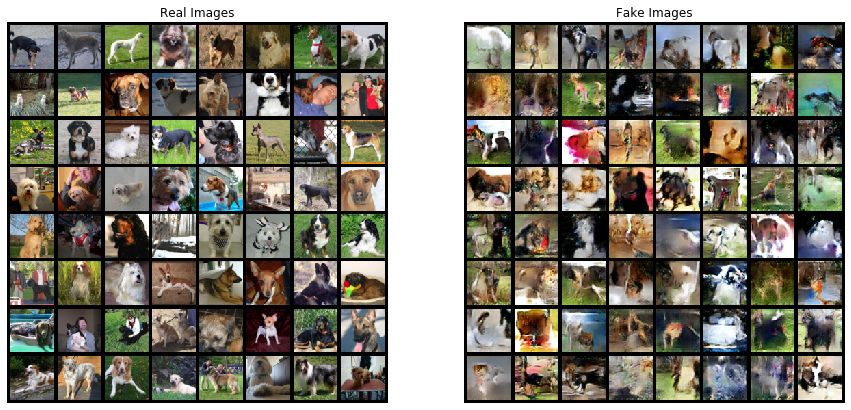

In [25]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
fake_images = generate_images(netG, nz, num_images = batch_size)
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(fake_images[-1].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
plt.show()

In [26]:
calculate_fid_given_images([real_batch[0][0:64].numpy(), fake_images[-1].numpy()], batch_size = batch_size)

spinning up model
done with super!
spun up!
batch size:  128
num images:  64


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

tensor([[[[ 0.3098,  0.3255,  0.3176,  ...,  0.1843,  0.2314,  0.2314],
          [ 0.2627,  0.2784,  0.2784,  ...,  0.1922,  0.2471,  0.2235],
          [ 0.2706,  0.2706,  0.2549,  ...,  0.2627,  0.2706,  0.2549],
          ...,
          [-0.2000, -0.1529, -0.1608,  ...,  0.0039, -0.0275, -0.0431],
          [-0.1686, -0.1451, -0.1294,  ...,  0.0039,  0.0039,  0.0118],
          [ 0.0039, -0.0824, -0.0824,  ...,  0.0118, -0.0588, -0.0588]],

         [[ 0.3176,  0.3333,  0.3255,  ...,  0.2000,  0.2392,  0.2314],
          [ 0.2706,  0.2863,  0.2863,  ...,  0.2078,  0.2549,  0.2314],
          [ 0.2784,  0.2784,  0.2627,  ...,  0.2784,  0.2784,  0.2627],
          ...,
          [-0.1686, -0.1137, -0.1216,  ...,  0.0353,  0.0039, -0.0118],
          [-0.1451, -0.1294, -0.1137,  ...,  0.0431,  0.0353,  0.0431],
          [ 0.0275, -0.0824, -0.0588,  ...,  0.0588, -0.0118, -0.0118]],

         [[ 0.3412,  0.3569,  0.3412,  ...,  0.2000,  0.2706,  0.2863],
          [ 0.2941,  0.3020,  

  0%|          | 0/1 [00:00<?, ?it/s]

batch size:  128
num images:  64


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

tensor([[[[-3.5550e-02, -7.5775e-02, -1.3111e-01,  ..., -5.2261e-03,
            1.0848e-01,  8.1555e-02],
          [ 1.9261e-02,  6.4954e-02, -2.1462e-02,  ...,  1.5851e-01,
            1.5350e-01,  2.1508e-01],
          [ 3.6371e-01,  4.3123e-01,  4.4974e-01,  ...,  1.8452e-01,
            1.1463e-01,  1.5854e-01],
          ...,
          [ 1.9074e-01,  3.7042e-01,  4.7856e-01,  ...,  1.6249e-01,
            1.9495e-01,  2.5638e-01],
          [ 2.0047e-01,  3.4356e-01,  5.3215e-01,  ...,  1.8034e-01,
            1.9035e-01,  2.5551e-01],
          [ 2.3641e-01,  3.5549e-01,  3.7886e-01,  ...,  1.9565e-01,
            2.4131e-01,  3.1896e-01]],

         [[-1.1668e-01, -1.8938e-01, -3.1579e-01,  ...,  7.4236e-02,
            6.7600e-02,  1.0447e-01],
          [-8.0912e-02,  3.4073e-03,  2.1436e-02,  ...,  2.9793e-01,
            2.3102e-01,  2.7613e-01],
          [ 3.2369e-01,  3.7757e-01,  4.2626e-01,  ...,  3.7079e-01,
            2.7858e-01,  2.5082e-01],
          ...,
     

            8.4047e-01,  8.5402e-01]]]])
torch.Size([64, 3, 64, 64])


100%|██████████| 1/1 [00:20<00:00, 20.83s/it]


271.0071057910198